In [15]:
debug = False

In [16]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey
import chex

class CMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    H: int  # horizon
    phi: jnp.array  # feature map
    rew: jnp.array  # reward function
    utility: jnp.array  # reward for constraint
    const: float  # constraint threshold
    P: jnp.array  # transition probability kernel
    init_dist: jnp.array  # initial distribution
    xi: float  # safety parameter
    safe_policy: Optional[jnp.array] = None
    optimal_policy: Optional[jnp.array] = None
    optimal_ret: Optional[jnp.array] = None  # optimal return

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


# Hyperparameters
S, A = 10, 3
d = S * A
H = 5

K = 500000  # number of episodes
# K = 1000  # number of episodes


In [3]:
def create_cmdp(key: PRNGKey) -> CMDP:
    const = 0  # dummy
    xi = 0  # dummy

    S_set = jnp.arange(S)
    A_set = jnp.arange(A)

    # feature map is one-hot vector
    d = S * A
    phi = jnp.eye(d)

    # create reward function
    rew = jnp.ones((H, S, A))
    key, _ = jax.random.split(key)
    zero_mask = jax.random.bernoulli(key, p=0.2, shape=rew.shape)
    rew = rew * zero_mask
    assert rew.shape == (H, S, A)
    assert rew.max() > 0

    # create reward function for constraints
    # utility = 1 - rew
    utility = jnp.ones((H, S, A))
    key, _ = jax.random.split(key)
    zero_mask = jax.random.bernoulli(key, p=0.2, shape=utility.shape)
    utility = utility * zero_mask
    assert utility.shape == (H, S, A)
    assert utility.max() > 0


    # create transition probability kernel
    key, _ = jax.random.split(key)
    P = jax.random.dirichlet(key=key, alpha=jnp.array([0.1] * S), shape=(H, S*A))
    P = P.reshape(H, S, A, S)
    np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)

    # create initial distribution
    key, _ = jax.random.split(key)
    init_dist = jnp.zeros(S)
    x0 = jax.random.randint(key, (), 0, S)
    init_dist = init_dist.at[x0].set(1.0)
    np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

    cmdp = CMDP(S_set, A_set, H, phi, rew, utility, const, P, init_dist, xi=xi)
    return cmdp


In [4]:
from scipy.optimize import linprog
from itertools import product
from functools import partial


@jax.jit
def compute_greedy_Q(cmdp: CMDP):
    """
    Compute a greedy Q function with respect to the utility function
    Useful for setting the constraint threshold
    """
    def backup(i, greedy_Q):
        h = H - i - 1
        V = greedy_Q[h+1].max(axis=1)
        next_v = cmdp.P[h] @ V
        chex.assert_shape(next_v, (S, A))
        greedy_Q = greedy_Q.at[h].set(cmdp.utility[h] + next_v)
        return greedy_Q

    greedy_Q = jnp.zeros((H+1, S, A))
    greedy_Q = jax.lax.fori_loop(0, cmdp.H, backup, greedy_Q)
    return greedy_Q[:-1]


def compute_optimal_policy(cmdp: CMDP):
    B = np.zeros((H, S, A, H, S, A))

    for s, a in product(range(S), range(A)):
        B[0, s, a, 0, s] = 1

    for h, s, a in product(range(1, H), range(S), range(A)):
        B[h, s, a, h, s] = 1
        B[h, s, a, h-1] = -cmdp.P[h-1, :, :, s]

    B = B.reshape((H*S*A, H*S*A))
    mu = np.repeat(cmdp.init_dist[:, None], A, axis=1).reshape(-1)
    b = np.hstack((mu, np.zeros((H-1)*S*A)))

    U = cmdp.utility.reshape(1, -1)
    u = np.array((cmdp.const,))

    r = - cmdp.rew.reshape(-1)
    lin_res = linprog(r, A_eq=B, b_eq=b, bounds=(0, None), A_ub=-U, b_ub=-u)

    d_arr = lin_res.x.reshape(H, S, A)
    np.testing.assert_allclose(d_arr.sum(axis=(1, 2)), 1.0, atol=1e-4)

    optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)
    optimal_policy = jnp.where(jnp.isnan(optimal_policy), 1 / cmdp.A, optimal_policy)
    return optimal_policy


@jax.jit
def EvalRegQ(policy: jnp.ndarray, rew: jnp.ndarray, P: jnp.ndarray, ent_coef: float, thresh_coef: float = 1.0) -> jnp.ndarray:
    """ Compute value function
    Args:
        policy (np.ndarray): (HxSxA) array
        rew (np.ndarray): (HxSxA) array
        P (np.ndarray): (HxSxSxA) array
        ent_coef (float): regularization parameter
        thresh_coef (float): threshold parameter

    Returns:
        Q (jnp.ndarray): (HxSxA)
    """

    def backup(i, args):
        policy_Q= args
        h = H - i - 1
        Q = policy_Q[h+1] + ent_coef * jax.scipy.special.entr(policy[h+1])
        V = (policy[h+1] * Q).sum(axis=1)
        next_v = P[h] @ V
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(rew[h] + next_v)
        min_thresh = thresh_coef * (1 + ent_coef * jnp.log(A)) * (H - h)
        policy_Q = jnp.maximum(jnp.minimum(policy_Q, min_thresh), 0)
        return policy_Q

    policy_Q= jnp.zeros((H+1, S, A))
    args = policy_Q
    policy_Q= jax.lax.fori_loop(0, H, backup, args)
    return policy_Q[:-1]



In [5]:
if debug:
    # test
    key = PRNGKey(0)
    cmdp = create_cmdp(key)
    test_feature = np.zeros(S*A)
    test_feature[A * 1 + 2] = 1
    np.testing.assert_allclose(cmdp.phi[A * 1 + 2], test_feature, atol=1e-4)

    # test
    uni_policy = jnp.ones((H, S, A)) / A
    Q_rew_reg = EvalRegQ(uni_policy, cmdp.rew, cmdp.P, 0.1)
    Q_rew= EvalRegQ(uni_policy, cmdp.rew, cmdp.P, 0)
    assert jnp.all(Q_rew_reg >= Q_rew)

In [6]:
@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, greedy_policy):
        greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
        return greedy_policy

    greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
    chex.assert_shape(greedy_policy, (H, S, A))
    return greedy_policy


def set_cmdp_info(cmdp: CMDP) -> CMDP:
    greedy_Q = compute_greedy_Q(cmdp)
    safe_policy = compute_greedy_policy(greedy_Q)
    maximum_utility = (greedy_Q).max(axis=-1)[0] @ cmdp.init_dist
    const = maximum_utility * 0.5
    xi = maximum_utility - const

    # Set safety related parameters
    cmdp = cmdp._replace(const=const, xi=xi, safe_policy=safe_policy)

    # set the optimal policy
    optimal_policy = compute_optimal_policy(cmdp)
    Q_rew= EvalRegQ(optimal_policy, cmdp.rew, cmdp.P, 0)
    Q_utility = EvalRegQ(optimal_policy, cmdp.utility, cmdp.P, 0)

    init_dist = cmdp.init_dist
    total_rew = ((Q_rew * optimal_policy)[0].sum(axis=-1) * init_dist).sum()
    total_utility = ((Q_utility * optimal_policy)[0].sum(axis=-1) * init_dist).sum()
    assert total_utility >= cmdp.const - 1e-5, f"total_utility: {total_utility}, const: {cmdp.const}"
 
    cmdp = cmdp._replace(optimal_policy=optimal_policy, optimal_ret=total_rew)
    return cmdp

In [7]:
if debug:
    # test
    cmdp = set_cmdp_info(cmdp)

In [8]:
@jax.jit
def deploy_policy_episode(mdp: CMDP, key: PRNGKey, policy: jnp.array, init_s: int):
    """ collect data through interaction to the mdp 
    Args:
        mdp (MDP)
        H (int)
        key (PRNGKey)
        policy (jnp.ndarray)
        init_s (int): initial state

    Returns:
        new_key (PRNGKey)
        traj (jnp.ndarray): (H x 3) collected trajectory H x (s, a, s')
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(policy, (H, S, A))

    def body_fn(h, args):
        key, s, traj = args
        key, new_key = jax.random.split(key)
        act = jax.random.choice(new_key, A, p=policy[h, s])

        # sample next state
        key, new_key = jax.random.split(key)
        next_s = jax.random.choice(new_key, mdp.S_set, p=mdp.P[h, s, act])

        sa = s * A + act
        traj = traj.at[h].add(jnp.array([sa, next_s]))
        return key, next_s, traj

    traj= jnp.zeros((H, 2), dtype=jnp.int32)  # H x (sa, s')
    args = key, init_s, traj
    key, _, traj = jax.lax.fori_loop(0, H, body_fn, args)
    return key, traj

In [9]:
@jax.jit
def sample_and_compute_regret(key, cmdp: CMDP, policy):
    # sample data and update visitation counter
    key, init_key = jax.random.split(key)
    init_s = jax.random.choice(init_key, S, p=cmdp.init_dist)
    key, traj = deploy_policy_episode(cmdp, key, policy, init_s)

    # compute temporal regret
    Q_rew= EvalRegQ(policy, cmdp.rew, cmdp.P, 0)
    Q_utility = EvalRegQ(policy, cmdp.utility, cmdp.P, 0)
    init_dist = cmdp.init_dist
    total_rew = ((Q_rew * policy)[0].sum(axis=-1) * init_dist).sum()
    total_utility = ((Q_utility * policy)[0].sum(axis=-1) * init_dist).sum()
    
    err_rew = (cmdp.optimal_ret * init_dist).sum() - total_rew
    err_vio = cmdp.const - total_utility
    return key, traj, err_rew, err_vio

In [10]:
def traj_to_phi_phi(traj: jnp.ndarray, cmdp: CMDP) -> jnp.ndarray:
    """ convert trajectory to phi phi^T
    Args:
        traj (jnp.ndarray): (H x 2) array

    Returns:
        phi_phi (jnp.ndarray): (H x d x d)
    """
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    phi_phi = jax.vmap(jnp.dot)(Phi.reshape(H, d, 1), Phi.reshape(H, 1, d))
    return phi_phi


def traj_to_phi_V(traj: jnp.ndarray, V: jnp.ndarray, cmdp: CMDP) -> jnp.ndarray:
    """ convert trajectory to phi phi^T
    Args:
        traj (jnp.ndarray): (H x 2) array
        V (jnp.ndarray): (H x S) array

    Returns:
        phi_V (jnp.ndarray): (H x d)
    """
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    V = V[jnp.arange(H), traj[:, 1]].reshape(H, 1)  # (H x 1)
    phi_V = jax.vmap(jnp.multiply)(Phi, V)
    return phi_V

In [11]:
if debug:
    # test
    key, traj = deploy_policy_episode(cmdp, key, uni_policy, 0)
    V = jax.random.uniform(key, (H, S))
    phi_phi = traj_to_phi_phi(traj, cmdp)
    phi_V = traj_to_phi_V(traj, V, cmdp)
    chex.assert_shape(phi_phi, (H, d, d))
    chex.assert_shape(phi_V, (H, d))

    # ===== compute bonus function =====
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda = Lambda + phi_phi
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)
    chex.assert_shape(Lambda_inv, (H, d, d))

    phi_Lambda_inv = jax.vmap(jnp.dot, in_axes=(None, 0))(cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))

    bonus = jax.vmap(jax.vmap(jnp.dot), in_axes=(None, 0))(cmdp.phi, Lambda_inv).reshape(H, S, A)

    # ===== compute estimated P =====
    mu = jnp.zeros((H, S, d))

    @jax.vmap
    def update_mu(mu, traj, phi_Lambda_inv):
        sa, ns = traj
        mu = mu.at[ns].add(phi_Lambda_inv[sa])
        return mu

    mu = update_mu(mu, traj, phi_Lambda_inv)
    chex.assert_shape(mu, (H, S, d))

    est_P = jax.vmap(jnp.dot, in_axes=(None, 0))(cmdp.phi, jnp.transpose(mu, (0, 2, 1))).reshape(H, S, A, S)

# Proposed Algorithm (Algorithm 2)

In [12]:
@jax.jit
def compute_Q_h(Q_nh: jnp.ndarray, pol_nh: jnp.ndarray, bonus_h: jnp.ndarray, rew_h: jnp.ndarray, P_h: jnp.ndarray, ent_coef: float, thresh: float) -> jnp.ndarray:
    Q_nh_reg = Q_nh + ent_coef * jax.scipy.special.entr(pol_nh)
    V_nh = (pol_nh * Q_nh_reg).sum(axis=1)

    next_v = bonus_h + P_h @ V_nh
    next_v = jnp.maximum(jnp.minimum(next_v, thresh), 0)
    chex.assert_shape(next_v, (S, A))
    return rew_h + next_v 


@jax.jit
def compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, lam):
    Q_h = dQ_h + rQ_h + lam * uQ_h
    return jax.nn.softmax(Q_h / ent_coef, axis=-1)


# test 
if debug:
    rQ = jnp.zeros((H+1, S, A))
    dQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    policy= jnp.ones((H+1, S, A)) / A

    i = 0
    h = H - i - 1

    Cr = d * H * 0.1
    Cu = Cr 
    Cd = d ** 2 * H ** 3 / cmdp.xi
    Bd = d * H ** 2 / cmdp.xi
    ent_coef = 1e-4

    rthresh = (1 + ent_coef * jnp.log(A)) * (H - h)
    rQ_h = compute_Q_h(rQ[h+1], policy[h+1], Cr * bonus[h], cmdp.rew[h], est_P[h], ent_coef, rthresh)

    dthresh = Bd * (H - h)
    dQ_h = compute_Q_h(dQ[h+1], policy[h+1], Cd * bonus[h], Bd * bonus[h], est_P[h], 0, dthresh)

    uthresh = (H - h)
    uQ_h = compute_Q_h(uQ[h+1], policy[h+1], -Cu * bonus[h], cmdp.utility[h], est_P[h], 0, uthresh)

    compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, 0.1)

In [13]:
@jax.jit
def compute_softmax_pol(bonus: jnp.ndarray, cmdp: CMDP, ent_coef: float, lam: float, Cr: float, Cd: float, Cu: float, Bd: float) -> jnp.ndarray:
    def backup(i, args):
        rQ, dQ, uQ, pol = args
        h = H - i - 1

        rthresh = (1 + ent_coef * jnp.log(A)) * (H - h)
        rQ_h = compute_Q_h(rQ[h+1], pol[h+1], Cr * bonus[h], cmdp.rew[h], cmdp.P[h], ent_coef, rthresh)

        dthresh = Bd * (H - h)
        dQ_h = compute_Q_h(dQ[h+1], pol[h+1], Cd * bonus[h], Bd * bonus[h], cmdp.P[h], 0, dthresh)

        uthresh = (H - h)
        uQ_h = compute_Q_h(uQ[h+1], pol[h+1], -Cu * bonus[h], cmdp.utility[h], cmdp.P[h], 0, uthresh)

        pol_h = compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, lam)

        rQ = rQ.at[h].set(rQ_h)
        dQ = dQ.at[h].set(dQ_h)
        uQ = uQ.at[h].set(uQ_h)
        pol = pol.at[h].set(pol_h)
        return rQ, dQ, uQ, pol

    rQ = jnp.zeros((H+1, S, A))
    dQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    pol = jnp.ones((H+1, S, A)) / A

    args = rQ, dQ, uQ, pol
    rQ, dQ, uQ, pol = jax.lax.fori_loop(0, H, backup, args)

    uV = jnp.sum(uQ * pol, axis=-1)
    total_util = cmdp.init_dist @ uV[0]
    return total_util, pol[:-1]

if debug:
    Clam = 1000
    est_cmdp = cmdp._replace(P=est_P)
    uV_up, pol_up = compute_softmax_pol(bonus, est_cmdp, ent_coef, Clam, Cr, Cd, Cu, Bd)
    uV_low, pol_low = compute_softmax_pol(bonus, est_cmdp, ent_coef, 0, Cr, Cd, Cu, Bd)
    print(jax.lax.cond(uV_up >= cmdp.const, lambda: 3, lambda: 2))

In [14]:
from functools import partial
import jax
import chex


@jax.jit
def update(k: int, args):
    key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum= args

    # hyperparameters
    scale = 10
    Cr = Cu =  scale * d * H
    Cd = scale * d ** 2 * H ** 3 / cmdp.xi
    # Bd = 0.1 * d * H ** 2 / cmdp.xi
    Bd = 1
    Clam = 0.1 * d * H ** 4 / (cmdp.xi ** 2)
    ent_coef = 0.1

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(jnp.maximum(err_vio, 0))

    # ===== compute bonus function =====
    phi_phi = traj_to_phi_phi(traj, cmdp)
    Lambda = Lambda + phi_phi
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)
    chex.assert_shape(Lambda_inv, (H, d, d))
    bonus = jax.vmap(jax.vmap(jnp.dot), in_axes=(None, 0))(cmdp.phi, Lambda_inv).reshape(H, S, A)

    # ===== compute estimated P =====
    @jax.vmap
    def update_ephi_sum(ephi_sum, traj):
        sa, ns = traj
        ephi_sum = ephi_sum.at[ns].add(cmdp.phi[sa])
        return ephi_sum

    ephi_sum = update_ephi_sum(ephi_sum, traj)
    mu = ephi_sum @ Lambda_inv
    chex.assert_shape(mu, (H, S, d))

    est_P = jax.vmap(jnp.dot, in_axes=(None, 0))(cmdp.phi, jnp.transpose(mu, (0, 2, 1))).reshape(H, S, A, S)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0, Clam), dtype=jnp.float32))
    _, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)
    return key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum


def RunAlgo(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    pol = cmdp.safe_policy

    args = key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum
    _, errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, update, args)
    return errors_rew, errors_vio

# Ghosh[2024]'s Algorithm

In [15]:

@jax.jit
def compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam):
    Q_h = rQ_h + lam * uQ_h
    return jax.nn.softmax(Q_h / ent_coef, axis=-1)


@jax.jit
def compute_softmax_pol_Ghosh(bonus: jnp.ndarray, cmdp: CMDP, ent_coef: float, lam: float, Cr: float, Cu: float) -> jnp.ndarray:
    def backup(i, args):
        rQ, uQ, pol = args
        h = H - i - 1

        thresh = H - h
        rQ_h = compute_Q_h(rQ[h+1], pol[h+1], Cr * bonus[h], cmdp.rew[h], cmdp.P[h], 0, thresh)
        uQ_h = compute_Q_h(uQ[h+1], pol[h+1], Cu * bonus[h], cmdp.utility[h], cmdp.P[h], 0, thresh)
        pol_h = compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam)

        rQ = rQ.at[h].set(rQ_h)
        uQ = uQ.at[h].set(uQ_h)
        pol = pol.at[h].set(pol_h)
        return rQ, uQ, pol

    rQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    pol = jnp.ones((H+1, S, A)) / A

    args = rQ, uQ, pol
    rQ, uQ, pol = jax.lax.fori_loop(0, H, backup, args)

    uV = jnp.sum(uQ * pol, axis=-1)
    total_util = cmdp.init_dist @ uV[0]
    return total_util, pol[:-1]


@jax.jit
def update_Ghosh(k: int, args):
    key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum = args

    # hyperparameters
    Cr = 10 * d * H
    Cu = 5 * d * H
    ent_coef = 0.1

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(jnp.maximum(err_vio, 0))

    # ===== compute bonus function =====
    phi_phi = traj_to_phi_phi(traj, cmdp)
    Lambda = Lambda + phi_phi
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)
    chex.assert_shape(Lambda_inv, (H, d, d))
    bonus = jax.vmap(jax.vmap(jnp.dot), in_axes=(None, 0))(cmdp.phi, Lambda_inv).reshape(H, S, A)

    # ===== compute estimated P =====
    @jax.vmap
    def update_ephi_sum(ephi_sum, traj):
        sa, ns = traj
        ephi_sum = ephi_sum.at[ns].add(cmdp.phi[sa])
        return ephi_sum

    ephi_sum = update_ephi_sum(ephi_sum, traj)
    mu = ephi_sum @ Lambda_inv
    chex.assert_shape(mu, (H, S, d))

    est_P = jax.vmap(jnp.dot, in_axes=(None, 0))(cmdp.phi, jnp.transpose(mu, (0, 2, 1))).reshape(H, S, A, S)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol_Ghosh(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cu)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0, jnp.sqrt(K)), dtype=jnp.float32))
    _, pol = compute_softmax_pol_Ghosh(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cu)
    return key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum


def RunAlgoGhosh(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    pol = cmdp.safe_policy

    args = key, errors_rew, errors_vio, pol, cmdp, Lambda, ephi_sum
    _, errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, update_Ghosh, args)
    return errors_rew, errors_vio

# Uniform policy

In [16]:
@jax.jit
def run_uni_policy(k: int, args):
    key, errors_rew, errors_vio, pol, cmdp = args

    # hyperparameters
    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(jnp.maximum(err_vio, 0))
    return key, errors_rew, errors_vio, pol, cmdp


def RunUniPolicy(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)
    pol = jnp.ones((H, S, A)) / A

    args = key, errors_rew, errors_vio, pol, cmdp
    _, errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, run_uni_policy, args)
    return errors_rew, errors_vio

# Run Algorithms

In [ ]:
import ray
ray.init(num_cpus=8)
NUM_SEEDS = 30


@ray.remote
class Buffer:
    def __init__(self):
        self.errors_rew = []
        self.errors_vio = []
        self.errors_rew_Ghosh = []
        self.errors_vio_Ghosh = []
        self.errors_rew_uni = []
        self.errors_vio_uni = []

    def add(self, errors_rew, errors_vio, errors_rew_Ghosh, errors_vio_Ghosh, errors_rew_uni, errors_vio_uni):
        self.errors_rew.append(errors_rew)
        self.errors_vio.append(errors_vio)
        self.errors_rew_Ghosh.append(errors_rew_Ghosh)
        self.errors_vio_Ghosh.append(errors_vio_Ghosh)
        self.errors_rew_uni.append(errors_rew_uni)
        self.errors_vio_uni.append(errors_vio_uni)

    def get(self):
        rew_list = np.array(self.errors_rew)
        vio_list = np.array(self.errors_vio)
        Ghosh_rew_list = np.array(self.errors_rew_Ghosh)
        Ghosh_vio_list = np.array(self.errors_vio_Ghosh)
        uni_rew_list = np.array(self.errors_rew_uni)
        uni_vio_list = np.array(self.errors_vio_uni)

        return rew_list, vio_list, Ghosh_rew_list, Ghosh_vio_list, uni_rew_list, uni_vio_list


@ray.remote
def run_algorithms(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    errors_rew, errors_vio = RunAlgo(cmdp, K, seed)
    errors_rew_Ghosh, errors_vio_Ghosh = RunAlgoGhosh(cmdp, K, seed)
    errors_rew_uni, errors_vio_uni = RunUniPolicy(cmdp, K, seed)

    buffer.add.remote(
        np.array(errors_rew),
        np.array(errors_vio),
        np.array(errors_rew_Ghosh),
        np.array(errors_vio_Ghosh),
        np.array(errors_rew_uni),
        np.array(errors_vio_uni)
    )


buffer = Buffer.remote()

jobs = []
for i in range(NUM_SEEDS):
    jobs.append(run_algorithms.remote(buffer, i))

_ = ray.get(jobs)

2025-05-06 01:29:24,067	INFO worker.py:1888 -- Started a local Ray instance.
(run_algorithms pid=19071) WARNING:2025-05-06 01:29:24,679:jax._src.xla_bridge:909: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
(run_algorithms pid=19072) /tmp/ipykernel_18769/1996800776.py:48: RuntimeWarning: invalid value encountered in divide


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
import pickle

with open("results.pkl", "wb") as f:
    results = ray.get(buffer.get.remote())
    pickle.dump(results, f)

In [24]:
import pickle
with open("results.pkl", "rb") as f:
    results = pickle.load(f)
    rew_list, vio_list, Ghosh_rew_list, Ghosh_vio_list, uni_rew_list, uni_vio_list = results

<Figure size 1000x500 with 0 Axes>

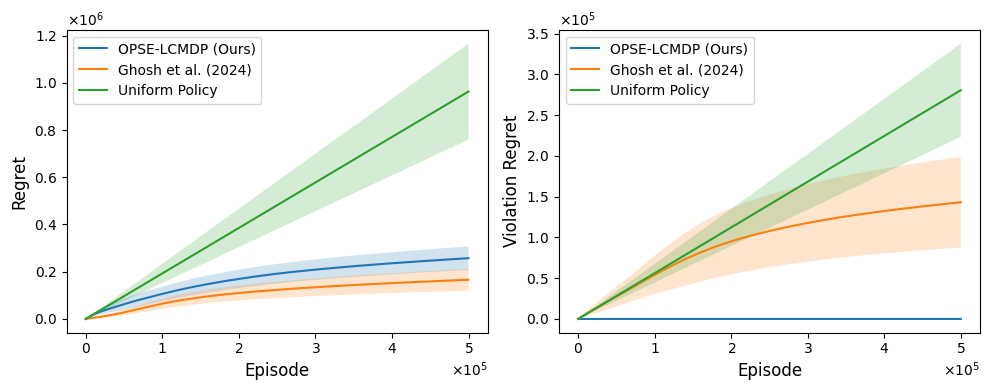

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


class FixedOrderFormatter(ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag


plt.figure(figsize=(10, 5))


# Compute cumulative sums
rew_cumsum = np.cumsum(rew_list, axis=1)
vio_cumsum = np.cumsum(vio_list, axis=1)
Ghosh_rew_cumsum = np.cumsum(Ghosh_rew_list, axis=1)
Ghosh_vio_cumsum = np.cumsum(Ghosh_vio_list, axis=1)
uni_rew_cumsum = np.cumsum(uni_rew_list, axis=1)
uni_vio_cumsum = np.cumsum(uni_vio_list, axis=1)

# Compute mean and std
resol = 100

rew_mean, rew_std = rew_cumsum.mean(axis=0)[::resol], rew_cumsum.std(axis=0)[::resol]
vio_mean, vio_std = vio_cumsum.mean(axis=0)[::resol], vio_cumsum.std(axis=0)[::resol]
Ghosh_rew_mean, Ghosh_rew_std = Ghosh_rew_cumsum.mean(axis=0)[::resol], Ghosh_rew_cumsum.std(axis=0)[::resol]
Ghosh_vio_mean, Ghosh_vio_std = Ghosh_vio_cumsum.mean(axis=0)[::resol], Ghosh_vio_cumsum.std(axis=0)[::resol]
uni_rew_mean, uni_rew_std = uni_rew_cumsum.mean(axis=0)[::resol], uni_rew_cumsum.std(axis=0)[::resol]
uni_vio_mean, uni_vio_std = uni_vio_cumsum.mean(axis=0)[::resol], uni_vio_cumsum.std(axis=0)[::resol]

epi = np.arange(len(rew_cumsum[0]))[::resol]

# Plot with std bars
fig = plt.figure(figsize=(10, 4))

# Plot cumulative reward
ax = fig.add_subplot(1, 2, 1)
ax.plot(epi, rew_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax.fill_between(epi, rew_mean - rew_std, rew_mean + rew_std, alpha=0.2)
ax.plot(epi, Ghosh_rew_mean, label="Ghosh et al. (2024)", rasterized=True)
ax.fill_between(epi, Ghosh_rew_mean - Ghosh_rew_std, Ghosh_rew_mean + Ghosh_rew_std, alpha=0.2)
ax.plot(epi, uni_rew_mean, label="Uniform Policy", rasterized=True)
ax.fill_between(epi, uni_rew_mean - uni_rew_std, uni_rew_mean + uni_rew_std, alpha=0.2)
ax
ax.set_ylabel("Regret", fontdict={"fontsize": 12})
ax.set_xlabel("Episode", fontdict={"fontsize": 12})
ax.legend()
ax.yaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# Plot cumulative violations
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epi, vio_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax2.fill_between(epi, vio_mean - vio_std, vio_mean + vio_std, alpha=0.2)
ax2.plot(epi, Ghosh_vio_mean, label="Ghosh et al. (2024)", rasterized=True)
ax2.fill_between(epi, Ghosh_vio_mean - Ghosh_vio_std, Ghosh_vio_mean + Ghosh_vio_std, alpha=0.2)
ax2.plot(epi, uni_vio_mean, label="Uniform Policy", rasterized=True)
ax2.fill_between(epi, uni_vio_mean - uni_vio_std, uni_vio_mean + uni_vio_std, alpha=0.2)
ax2.set_ylabel("Violation Regret", fontdict={"fontsize": 12})
ax2.set_xlabel("Episode", fontdict={"fontsize": 12})
ax2.legend()
ax2.yaxis.set_major_formatter(FixedOrderFormatter(6 ,useMathText=True))
ax2.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax2.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax2.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

plt.tight_layout()
plt.savefig("results.pdf")